In [1]:
from itertools import cycle
from math import pi

import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize_scalar
from Materials import Gold 
from Geometry import Nanosphere

from netgen.csg import *
from ngsolve import *

In [2]:

def IncidentWave(wavelength):

    k = 2*pi*n / wavelength 
	return CoefficientFunction((0,exp(-1J*k*x),0))

def RelativePermittivity(wavelength,delta_n=0.2):

    permittivities = {"water" : 1.33**2, "gold" : Gold(wavelength), "pml" : 1.33**2}
    return CoefficientFunction([permittivities[mat] for mat in mesh.GetMaterials()])
    # sqrt(y**2) is for absolute value of y

    # a = sqrt(x**2+z**2)
    # r = sqrt(x**2+(sqrt(y**2)-rod_length/2)**2+z**2)
    # r0 = sqrt(x**2+y**2+z**2)

    # mt_sphere = n + delta_n*(radius/r0)**2
    # mt_mid = n + delta_n*(radius/a)
    # mt_end = n + delta_n*(radius/r)**2

    # permittivities = {"water" : 1.33**2, 
    # 				   "gold" : Gold(wavelength), 
    # 				   "pml" : 1.33**2, 
    # 				   "mt_mid" : mt_mid**2, 
    # 				   "mt_end" : mt_end**2, 
    # 				   "mt_sphere" : mt_sphere**2,
    # 				   "mt_cyl" : 1.414**2}



def GetEsc(wavelength,mat=False):

	Esc = GridFunction(fes)
	Einc = IncidentWave(wavelength)

	k = 2*pi / wavelength
	eps_r = RelativePermittivity(wavelength)

	a = BilinearForm(fes,symmetric=True)
	a += (curl(E)*curl(W)-k*k*eps_r*E*W)*dx
	a += -1J*k*E.Trace()*W.Trace()*ds('outer')

	p = mesh.Materials('gold') + mesh.Materials('mt_mid') + mesh.Materials('mt_end') + mesh.Materials('mt_sphere')

	f = LinearForm(fes)
	f += (eps_r-n**2)*k**2*Einc*W*dx(p)

	if mat:
		a.Assemble()
		f.Assemble()
		return a,f 
	else:
		c = Preconditioner(a,'bddc', inverse="sparsecholesky")
		a.Assemble()
		f.Assemble()
		Esc.vec.data = solvers.GMRes(a.mat,f.vec,pre=c.mat,printrates=False,restart=750)

	return Esc

def Error(wavelength):

    p = mesh.Materials('gold') + mesh.Materials('mt_mid') + mesh.Materials('mt_end') + mesh.Materials('water') + mesh.Materials('mt_sphere')

    Esc = GetEsc(wavelength)
    Esc_approx = GridFunction(fesLO)
    Esc_approx.Set(Esc)

    err_func = Norm(Esc-Esc_approx)
    elerr_phy = Integrate(err_func,mesh,element_wise=True,definedon=p)
    elerr = Integrate(err_func,mesh,element_wise=True)
    maxerr = max(elerr_phy)

    return elerr, maxerr

def RefineMesh(min,max):

    mid = (min + max)/2
    elerr, maxerr = Error(mid)

    print("DoF: ",fes.ndof)
    print("Max Error: ", maxerr)

    if maxerr < 250:
        return

    else:
        for el in mesh.Elements():
            mesh.SetRefinementFlag(el, elerr[el.nr] > .7*maxerr and (el.mat != 'pml'))

        mesh.Refine()
        fes.Update()
        fesLO.Update()

        mid1 = (min + mid)/2
        mid2 = (max + mid)/2

        error1 = Error(mid1)[1]
        error2 = Error(mid2)[1]

        if error1 > error2:
            RefineMesh(mid1,mid)
        else:
            RefineMesh(mid,mid2)

def Extinction(wavelength):

    print("Wavelength: ",wavelength)
	k = 2*pi / wavelength
	eps_r = RelativePermittivity(wavelength)

	Einc = IncidentWave(wavelength)
	Esc = GetEsc(wavelength)
	E = Einc + Esc
	
	p = mesh.Materials('gold') + mesh.Materials('mt_mid') + mesh.Materials('mt_end') + mesh.Materials('mt_sphere')

	ext = 1e-18*k*Integrate((eps_r-1)*E*Conj(Einc),mesh,definedon=p).imag
	return -ext



TabError: inconsistent use of tabs and spaces in indentation (<ipython-input-2-9f6a5e6e99e7>, line 4)

In [3]:
mesh = Nanosphere(40,0)
fes = HCurl(mesh,order=2,complex=True)
fesLO = HCurl(mesh,order=1,complex=True)
E,W = fes.TnT()

n = 1.33


In [4]:
%%time
RefineMesh(400,700)

DoF:  25332
Max Error:  10209.215384595627
DoF:  66272
Max Error:  2854.1263128714822
DoF:  80145
Max Error:  1643.4839071530075
DoF:  173679
Max Error:  910.1639549377895
DoF:  300292
Max Error:  435.24385628138634
Wall time: 3min 8s


In [7]:
%%time
wavelength_list = np.linspace(400,700,40)
ext_list = np.array([(wavelength,Extinction(wavelength)) for wavelength in wavelength_list])

Wall time: 20min 51s


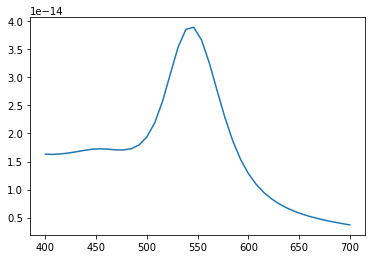

In [8]:
plt.plot(ext_list[:,0],-ext_list[:,1])